File of Perceptron.py  https://github.com/Pbabu-Github/csci-0451/blob/main/posts/perceptron/perceptron.py

In [1]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

## Abstract
In this blog post, I implement the perceptron algorithm using PyTorch. I experiment with linear boundaries that separate two classes in a dataset, as well as cases where a clear separation does not exist. My implementation includes a LinearModel class for basic operations (computing scores and predictions) and a Perceptron subclass that defines the loss (misclassification rate) and gradient update. The algorithm updates its weight vector whenever a data point is misclassified. Additionally, I use visualization functions to display the training data and, for 2D cases, both the decision boundary and the evolution of the loss over time.

## Walk through of Grad function

The grad() function in my implementation is responsible for computing the weight update for a single example. So what i did was:

* First, I made sure the data point X is in the right shape. If it came in as a row (1, p), I turned it into a 1D vector (p,).

* Then I checked if the label y is in {-1, 1}. If it wasnt, I converted it using y_mod = 2 * y - 1.

* I calculated the score by taking the dot product of the weights and the input (s = w • x). This score tells us how far the point is from the decision boundary.

* If s * y_mod is less than 0, that means the point is misclassified, so I returned the gradient as -y_mod * X. This will move the weights in the right direction.

* If the point was classified correctly, I just returned a zero vector (so there would be no update needed).

This matches the perceptron update rule taht if a point is wrong, we update the weights with (2y - 1) * x. Lets now perfom some experiments to check our implementation. Before that, teh code below does a simple check to see if our implementation is working by creating 2d data and perfroms the training and prints our loss after our update step.



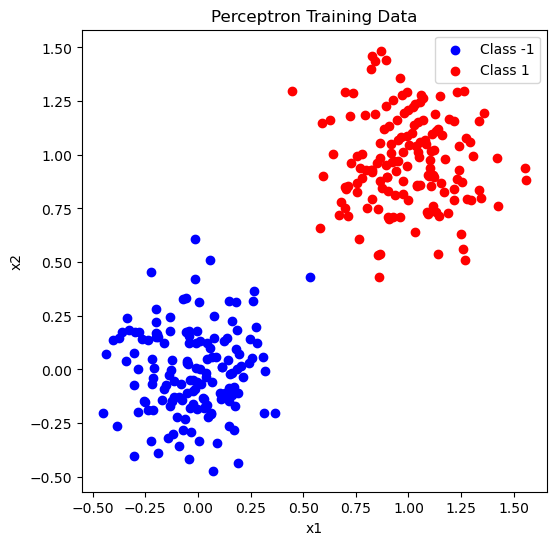

Loss after one step: 1.0


In [2]:
import torch
import matplotlib.pyplot as plt
from perceptron import Perceptron, PerceptronOptimizer, perceptron_data, plot_perceptron_data

# Generate the 2D data.
X, y = perceptron_data(n_points=300, noise=0.2)

# Plot the training data.
fig, ax = plt.subplots(figsize=(6, 6))
plot_perceptron_data(X, y, ax)
ax.set_title("Perceptron Training Data")
plt.show()

# Create a perceptron and an optimizer.
p = Perceptron()
opt = PerceptronOptimizer(p)
loss = opt.step(X[0:1], y[0])  # update using a single data point.
print("Loss after one step:", loss.item())


## Experiment 1: Perceptron Training on 2D data

In the experiment below, I use the perceptron algorithm to classify 2D data that is linearly separable.

* We first generate 2D data using `perceptron_data()`, which creates two clearly separated classes and adds a bias column.
* We next initialize a `Perceptron` model and an optimizer. For each iteration we calculate the current loss (misclassification rate), randomly select a single data point and if the model misclassifies it, we update the weights using the Perceptron rule.

* We repeat this until the model achieves zero loss or we reach the maximum number of iterations.


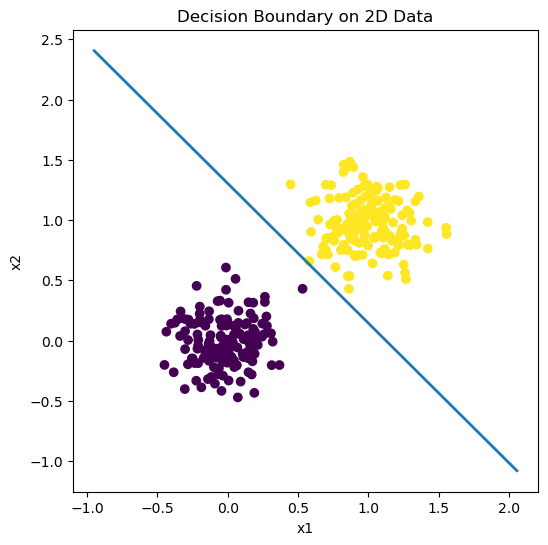

In [9]:
# Experiment 1: 2D Data (Linearly Separable
X2, y2 = perceptron_data(n_points=300, noise=0.2)  #generate 2d data 
p2 = Perceptron()
opt2 = PerceptronOptimizer(p2)
loss_vec = []
n = X2.size(0)
max_iter = 1000
for _ in range(max_iter):
    loss = p2.loss(X2, y2)
    loss_vec.append(loss.item())
    if loss.item() == 0: break
    i = torch.randint(n, (1,))
    opt2.step(X2[[i], :], y2[i])
 

#Plot decision boundary on 2D data:
w = p2.w  # final weight vector: [w1, w2, bias]
x1_vals = torch.linspace(X2[:,0].min()-0.5, X2[:,0].max()+0.5, 100)
x2_vals = -(w[0]*x1_vals + w[2]) / w[1]  # boundary: w1*x1 + w2*x2 + bias = 0
plt.figure(figsize=(6,6))
plt.scatter(X2[:,0], X2[:,1], c=y2)
plt.plot(x1_vals, x2_vals,  linewidth=2)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Decision Boundary on 2D Data")
plt.show()


Visualizing the loss evolution

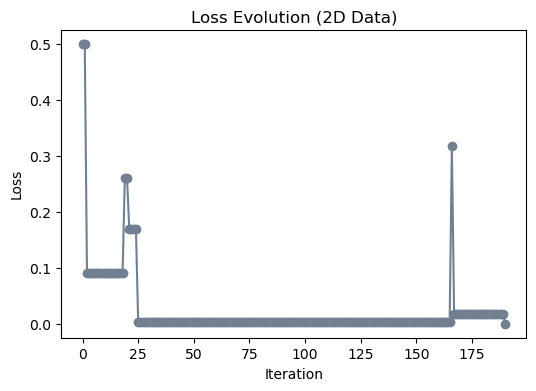

In [10]:
#plot loss evolution
plt.figure(figsize=(6,4))
plt.plot(loss_vec, marker='o', color='slategrey')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Evolution (2D Data)")
plt.show()

After training we plot the **loss vs. iteration** to show how the loss decreases as the model learns adn we also plot the final **decision boundary** over the 2D data. The red and blue dots show the two classes and the straight line separates them. This shows that the perceptron can successfully find a separating line when the data is linearly separable.

## Runtime Complexity of a Single Perceptron Iteration
In each iteration of perceptron training, we:

* Compute a dot product between the weight vector `w` and a single input example `x`. If `x` has `p` features, this takes **O(p)** time.
* If the example is misclassified, we compute the gradient and update the weights — this also takes **O(p)** time.

So overall, a **single iteration takes O(p) time**. It doesn't depend on the total number of data points `n`, because we only update using one randomly selected point per iteration.

Looking at the **Loss Evolution** graph above, we can also see that the model usually improves quickly (loss drops) and then flattens out. Even if a spike happens, it corrects quickly with just a couple more iterations. This shows that each iteration is efficient and contributes quickly to learning — especially when the data is linearly separable like in our 2D example.

## Experiment 2: Perceptron Training on High-Dimensional Data (3 Features)

In this experiment, I train the perceptron algorithm on a dataset with **5 features** instead of just 2.

* We generate high-dimensional data using `high_dim_data()`, which creates 5-dimensional data points (4 random features plus a constant column for bias). The two classes are linearly separable, but harder to visualize.
* We initialize a `Perceptron` model and an optimizer. As before, in each iteration we:
    - calculate the current loss,
    - randomly select a data point, and
    - apply the perceptron update rule if that point is misclassified.
* We keep updating until the loss reaches zero or we hit the maximum number of iterations.


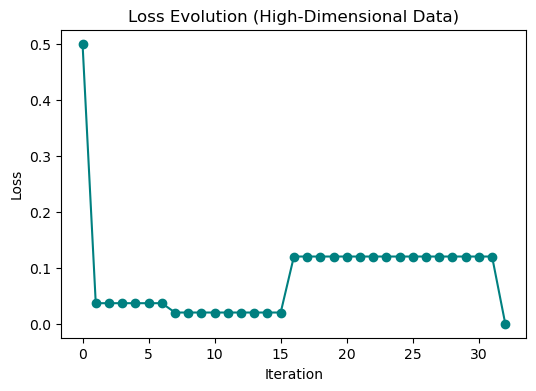

In [14]:

#  Experiment 2: High-Dimensional Data (5 Features) 
def high_dim_data(n_points=300, noise=0.2, p_dims=5):
    # Generate data with p_dims-1 features and append constant column.
    y = torch.arange(n_points) >= n_points//2
    X = y[:, None].float() + torch.normal(0.0, noise, size=(n_points, p_dims-1))
    X = torch.cat((X, torch.ones((n_points, 1))), 1)
    y = 2 * y.float() - 1  # convert targets to {-1, 1}
    return X, y

X5, y5 = high_dim_data(n_points=300, noise=0.2, p_dims=5)
p5 = Perceptron()
opt5 = PerceptronOptimizer(p5)
loss_vec_hd = []
n_hd = X5.size(0)
for _ in range(max_iter):
    loss = p5.loss(X5, y5)
    loss_vec_hd.append(loss.item())
    if loss.item() == 0: break
    i = torch.randint(n_hd, (1,))
    opt5.step(X5[[i], :], y5[i])
    
# Plot loss evolution for high-dimensional data:
plt.figure(figsize=(6,4))
plt.plot(loss_vec_hd, marker='o', color='teal')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Evolution (High-Dimensional Data)")
plt.show()


Since the data lives in more than 2 dimensions, we cannot directly plot the decision boundary. But we still visualize the loss over time to see how the model is learning and the graph above shows that the perceptron is still able to learn from high-dimensional data. The loss decreases quickly, though it fluctuates a bit more than in the 2D case — this is makes sense, because higher dimensions can make it harder to find a good separating boundary.

## Runtime Complexity of a Single Perceptron Iteration (High-Dimensional Case)

Even though the data has more features now, the complexity of each iteration stays the same:

* We compute the dot product `w · x` where `x` has `p` features → this takes O(p) time.
* If the point is misclassified, the gradient computation and weight update also take O(p) time.

So a single update step still runs in O(p) time. The number of data points `n` does not affect the time for each step because we’re only using one data point per iteration.

From the Loss Evolution graph above, we can see that perceptron learns effectively. The drops in loss happen fast, confirming that even in high dimensions, each iteration helps the model improve quickly — as long as the data is linearly separable.

Experiment 3: Perceptron on  2D Data that is not linearly Separable


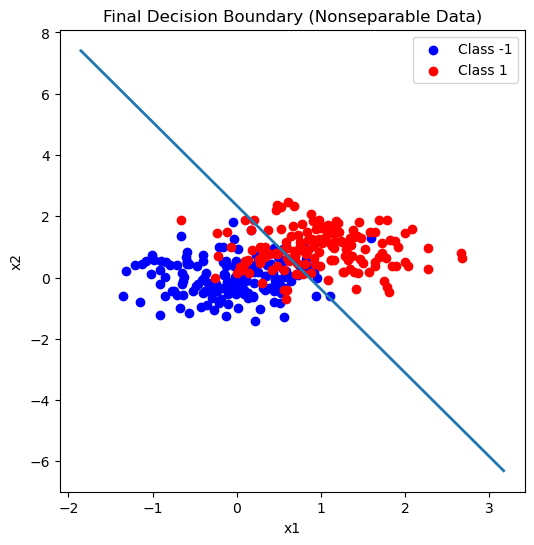

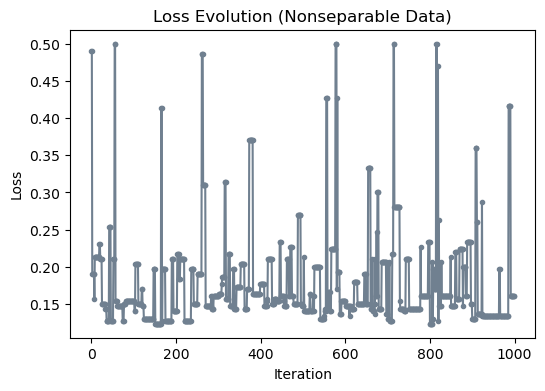

In [15]:
# Generate nonseparable 2D data by increasing noise.
X_ns, y_ns = perceptron_data(n_points=300, noise=0.6)
p_ns = Perceptron()
opt_ns = PerceptronOptimizer(p_ns)
loss_vec = []
n = X_ns.size(0)
max_iter = 1000

# Training loop: update on a random point each iteration.
for _ in range(max_iter):
    loss = p_ns.loss(X_ns, y_ns).item()
    loss_vec.append(loss)
    # If by chance loss becomes 0, we could break—but for nonseparable data, it won't.
    i = torch.randint(n, (1,))
    opt_ns.step(X_ns[[i], :], y_ns[i])


# Plot the data and the final decision boundary.
w = p_ns.w  # final weight vector [w1, w2, bias]
x_vals = torch.linspace(X_ns[:,0].min()-0.5, X_ns[:,0].max()+0.5, 100)
y_vals = -(w[0]*x_vals + w[2]) / w[1]  # decision boundary: w1*x + w2*y + bias = 0
plt.figure(figsize=(6,6))
ax = plt.gca()
plot_perceptron_data(X_ns, y_ns, ax)
ax.plot(x_vals, y_vals, linewidth=2)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Final Decision Boundary (Nonseparable Data)")
plt.show()

# Plot evolution of loss.
plt.figure(figsize=(6,4))
plt.plot(loss_vec, marker='o', markersize=3, color='slategrey')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Evolution (Nonseparable Data)")
plt.show()


In our experiment above , I tested the perceptron algorithm on 2D data that is not linearly separable by increasing the noise when generating data with `perceptron_data()`.

* We use a noise level of `0.6` which causes the two classes to overlap significantly. This makes it impossible to draw a perfect straight line that separates all the points.
* We then train the perceptron for up to 1000 iterations. Like before, we calculate the loss at each step and perform updates on a randomly chosen data point.

* After training, we plot the loss over time and the final decision boundary. Since the data is not linearly separable, the loss never reaches zero. The model keeps fluctuating as it tries to fit the noisy data.

The plot of the final decision boundary shows that the perceptron still finds a line that roughly splits the two classes, but some red and blue points are still on the wrong side. The loss curve also shows this as it goes around up and down and never stays flat like it did in the previous experiments. This shows a key limitation of the basic perceptron that it only works well when the data is linearly separable

## Implementing Minibatch Perceptron

## Walk through of grad function in Minibatch implementation

The grad() function in my minibatch implementation is responsible for computing the weight updates for multiple examples at once (a minibatch). I did this by

* First, I made sure the labels (`y`) were in the set {-1, 1}. If they weren't, I converted them using:
  ```python
  y_mod = torch.where((y == 1) | (y == -1), y, 2 * y - 1)
  ```

* Then, I calculated the scores (`s`) for the entire minibatch simultaneously by multiplying the feature matrix (`X`) by the weight vector (`w`):
  ```python
  s = X @ self.w
  ```

* After that, I checked which data points were misclassified by seeing where `s * y_mod` was less than 0.

* If there were any misclassified points, I computed the gradient by averaging the updates from all misclassified points:
  ```python
  grad = -(y_mod[misclassified, None] * X[misclassified]).mean(dim=0)
  ```

* If all points were classified correctly, I simply returned a zero vector (since no update would be needed).

This matches the minibatch perceptron update rule: if multiple points are wrong, we average their updates together to adjust our weights efficiently. Let's now perform some experiments with different batch sizes to check how this implementation performs.


In the code below, I implemented the Minibatch Perceptron algorithm to examine how varying the batch size (k) impacts the training process and convergence behavior.

The function minibatch(batch_size) performs training on randomly selected subsets (minibatches) of data points. Each minibatch is used to update the perceptron weights according to the perceptron learning rule.

Within the training loop, the loss is calculated after every update and we store it in the loss_history. If the loss reaches zero (which would indicate perfect classification), the training stops early.

We then by visualize the evolution of the loss, showing how quickly and effectively the perceptron learns for each specified minibatch size.

I will be calling this function with various batch sizes (k=1, k=10, k=n) to show how the perceptron’s learning rate differ across these scenarios:

In [99]:
import torch
from perceptron import Perceptron, PerceptronOptimizer, perceptron_data
import matplotlib.pyplot as plt

# Generate data
X, y = perceptron_data(n_points=300, noise=0.2)
# Create a perceptron and an optimizer
model = Perceptron()
optimizer = PerceptronOptimizer(model)
max_iter = 1000
alpha = 0.1  # Learning rate

def minibatch(batch_size):
    # Loss tracking
    loss_history = []

    for _ in range(max_iter):
        indices = torch.randperm(X.size(0))[:batch_size]  # random minibatch selection
        X_batch, y_batch = X[indices], y[indices]

        loss = optimizer.step(X_batch, y_batch, alpha)
        loss_history.append(loss.item()) # adding loss to history

        # we stop if loss reaches zero (perfect separation)
        if loss.item() == 0:
            break

    # Plot loss evolution
    plt.figure(figsize=(6, 4))
    plt.plot(loss_history, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(f"Loss Evolution (Minibatch size: {batch_size})")
    plt.show()


### Experiment: Minibatch Size = 1

In this experiment, I set the minibatch size to 1, which is the same as the standard perceptron update rule (one point at a time). As shown in the plot, the model quickly converges — it only takes two iterations for the loss to drop from 1.0 to 0.0. This is because when the data is linearly separable, since each misclassified point directly contributes to updating the weights. It confirms that this minibatch implementation works just like the regular perceptron when `k = 1`.


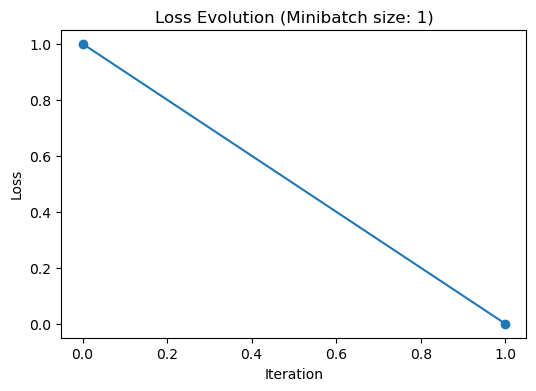

In [100]:
minibatch(1)#when batch size is 1

### Experiment: Minibatch Size = 10

In this experiment, I set the minibatch size to 10. The perceptron model updates its weights using 10 data points at a time instead of just one. As shown in the graph, the loss starts high and fluctuates for the first few steps, but overall it keeps going down. Around the 10th iteration, the model reaches zero loss, which means it has learned to classify the data correctly. This shows that using a small batch size still works well and the model is able to find a good separating line.


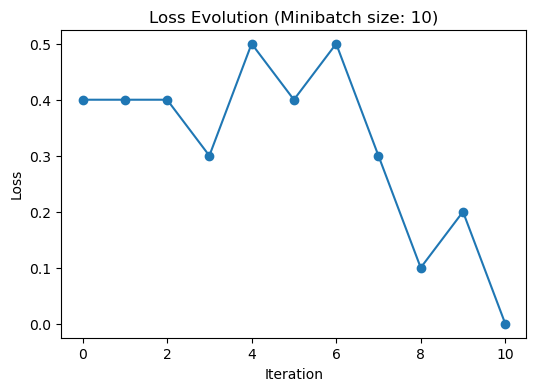

In [102]:
minibatch(10)# batch size 10

### Experiment: Minibatch Size = n

In this experiment, I used a minibatch size of 300 because we have 300 points, which means the perceptron updates its weights using the entire dataset at each step. As shown in the plot, the loss starts off high and stays flat for a few steps, but then it begins to decrease smoothly. By the 12th iteration, the loss reaches almost zero. This shows that even when using the whole dataset at once, the perceptron is still able to learn and improve — just a bit more gradually. The updates are more stable and less noisy compared to smaller batch sizes.


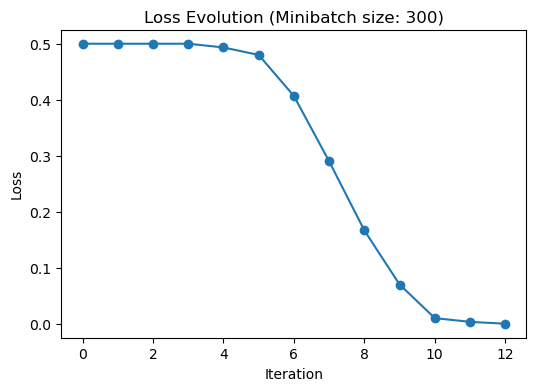

In [61]:
minibatch(300)# batch size 300 which is the number of points

## Runtime Complexity of Minibatch implementation

In my minibatch perceptron implementation, each iteration takes time based on how many points are in the batch and how many features each point has. If the batch has `k` points and each point has `p` features, then the runtime is O(kp). This means the more features or bigger the batch, the it will take longer for each update to happen.

## Conclusion

In this blog post, I learned to build and implement the Perceptron algorithm using PyTorch. I started with linearly separable data and showed that the perceptron can successfully learn a straight-line boundary that separates the two classes. Then, I tried the algorithm on higher-dimensional data and saw that it still learns well. Finally, I tested it on noisy, nonseparable data and noticed that the perceptron could not find a perfect boundary, and the loss never reached zero.

These experiments show that the perceptron works best when the data is linearly separable. It's fast and simple, but has limitations when data is noisy or can't be split with a straight line.

I also learnt how the perceptron behaves under different minibatch sizes. With small batches (like 1 or 10), the model updates quickly but sometimes with more noise. Using the entire dataset as a batch (size 300) made the updates smoother and more stable, though slightly slower. Overall, these experiments helped me understand how minibatch size affects convergence and learning behavior in perceptron training.
